## Work
1. 請比較使用 l1, l1_l2 及不同比例下的訓練結果

Ans:　
regulizer ratio 為 le-8時 無論是L1 或L1+L2 得到的loss及accurary都是最好 (相比1e-2, 1e-4, 1e-12)
至於L1及L1+L2的在le-8的結果差異並不大


In [1]:
import os
import keras

# Disable GPU
os.environ["CUDA_VISIBLE_DEVICES"] = ""

Using TensorFlow backend.


In [2]:
train, test = keras.datasets.cifar10.load_data()

In [3]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [4]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [6]:
from keras.regularizers import l1, l2, l1_l2

"""
建立神經網路，並加入 L1 或 L2
"""
def build_mlp(input_shape,regularizer_type, output_units=10, num_neurons=[512, 256, 128], l2_ratio=1e-4):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            if regularizer_type =='l1_type':
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1(l2_ratio))(input_layer)
            elif regularizer_type =='l1_l2_type':
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1), 
                                       kernel_regularizer=l1_l2(l2_ratio))(input_layer)
        else:
            if regularizer_type =='l1_type':
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l2(l2_ratio))(x)
            elif regularizer_type =='l1_l2_type':
                x = keras.layers.Dense(units=n_units, 
                                       activation="relu", 
                                       name="hidden_layer"+str(i+1),
                                       kernel_regularizer=l2(l2_ratio))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [7]:
"""Code Here
設定超參數
"""
## 超參數設定
LEARNING_RATE = 1e-3
EPOCHS = 50
BATCH_SIZE = 256
MOMENTUM = 0.95
L2_EXP = [1e-2, 1e-4, 1e-8, 1e-12]

regul_type_def = ['l1_type','l1_l2_type']


In [8]:
results = {}
"""Code Here
撰寫你的訓練流程並將結果用 dictionary 紀錄
"""
for regulizer_ratio in L2_EXP:
    for regul_type in regul_type_def:
        keras.backend.clear_session() # 把舊的 Graph 清掉
        print("Experiment with Regulizer = %.6f, type=%s" % (regulizer_ratio,regul_type))
        model = build_mlp(input_shape=x_train.shape[1:],regularizer_type =regul_type, l2_ratio=regulizer_ratio)
        model.summary()
        optimizer = keras.optimizers.SGD(lr=LEARNING_RATE, nesterov=True, momentum=MOMENTUM)
        model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

        model.fit(x_train, y_train, 
                  epochs=EPOCHS, 
                  batch_size=BATCH_SIZE, 
                  validation_data=(x_test, y_test), 
                  shuffle=True)

        # Collect results
        train_loss = model.history.history["loss"]
        valid_loss = model.history.history["val_loss"]
        train_acc = model.history.history["acc"]
        valid_acc = model.history.history["val_acc"]

        exp_name_tag = "exp-l2-%s type=%s" % (str(regulizer_ratio),regul_type)
        results[exp_name_tag] = {'train-loss': train_loss,
                                 'valid-loss': valid_loss,
                                 'train-acc': train_acc,
                                 'valid-acc': valid_acc}

W0720 22:07:59.046741 10364 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:95: The name tf.reset_default_graph is deprecated. Please use tf.compat.v1.reset_default_graph instead.

W0720 22:07:59.049736 10364 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:98: The name tf.placeholder_with_default is deprecated. Please use tf.compat.v1.placeholder_with_default instead.

W0720 22:07:59.076741 10364 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:102: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0720 22:07:59.078741 10364 deprecation_wrapper.py:119] From C:\ProgramData\Anaconda3\lib\site-packages\keras\backend\tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0720 22:07:59.081742 10364 

Experiment with Regulizer = 0.010000, type=l1_type
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


W0720 22:07:59.451735 10364 deprecation.py:323] From C:\ProgramData\Anaconda3\lib\site-packages\tensorflow\python\ops\math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where


Train on 50000 samples, validate on 10000 samples
Epoch 1/50
50000/50000 [==============================] - 18s 354us/step - loss: 148.2930 - acc: 0.2529 - val_loss: 14.2402 - val_acc: 0.2895
Epoch 2/50
50000/50000 [==============================] - 17s 339us/step - loss: 7.2788 - acc: 0.1730 - val_loss: 6.2521 - val_acc: 0.1445
Epoch 3/50
50000/50000 [==============================] - 17s 331us/step - loss: 5.9480 - acc: 0.1591 - val_loss: 5.6625 - val_acc: 0.1578
Epoch 4/50
50000/50000 [==============================] - 16s 325us/step - loss: 5.3951 - acc: 0.1675 - val_loss: 5.1441 - val_acc: 0.1746
Epoch 5/50
50000/50000 [==============================] - 16s 326us/step - loss: 4.9256 - acc: 0.1763 - val_loss: 4.7174 - val_acc: 0.1811
Epoch 6/50
50000/50000 [==============================] - 16s 327us/step - loss: 4.5327 - acc: 0.1810 - val_loss: 4.3588 - val_acc: 0.1941
Epoch 7/50
50000/50000 [==============================] - 16s 327us/step - loss: 4.2037 - acc: 0.1851 - val_loss:

50000/50000 [==============================] - 19s 385us/step - loss: 146.4540 - acc: 0.2565 - val_loss: 11.5953 - val_acc: 0.2839
Epoch 2/50
50000/50000 [==============================] - 19s 376us/step - loss: 7.0592 - acc: 0.1553 - val_loss: 6.2767 - val_acc: 0.1340
Epoch 3/50
50000/50000 [==============================] - 19s 374us/step - loss: 5.9764 - acc: 0.1596 - val_loss: 5.6928 - val_acc: 0.1571
Epoch 4/50
50000/50000 [==============================] - 19s 373us/step - loss: 5.4376 - acc: 0.1573 - val_loss: 5.1896 - val_acc: 0.1602
Epoch 5/50
50000/50000 [==============================] - 19s 373us/step - loss: 4.9680 - acc: 0.1652 - val_loss: 4.7525 - val_acc: 0.1696
Epoch 6/50
50000/50000 [==============================] - 19s 374us/step - loss: 4.5645 - acc: 0.1714 - val_loss: 4.3830 - val_acc: 0.1759
Epoch 7/50
50000/50000 [==============================] - 19s 372us/step - loss: 4.2250 - acc: 0.1800 - val_loss: 4.0939 - val_acc: 0.1780
Epoch 8/50
50000/50000 [===========

Epoch 2/50
50000/50000 [==============================] - 16s 323us/step - loss: 4.9937 - acc: 0.3650 - val_loss: 4.9226 - val_acc: 0.3728
Epoch 3/50
50000/50000 [==============================] - 16s 325us/step - loss: 4.8548 - acc: 0.3961 - val_loss: 4.7945 - val_acc: 0.4021
Epoch 4/50
50000/50000 [==============================] - 16s 326us/step - loss: 4.7402 - acc: 0.4147 - val_loss: 4.6848 - val_acc: 0.4244
Epoch 5/50
50000/50000 [==============================] - 16s 325us/step - loss: 4.6349 - acc: 0.4321 - val_loss: 4.5957 - val_acc: 0.4310
Epoch 6/50
50000/50000 [==============================] - 16s 322us/step - loss: 4.5391 - acc: 0.4438 - val_loss: 4.4997 - val_acc: 0.4435
Epoch 7/50
50000/50000 [==============================] - 16s 325us/step - loss: 4.4481 - acc: 0.4577 - val_loss: 4.4167 - val_acc: 0.4542
Epoch 8/50
50000/50000 [==============================] - 17s 335us/step - loss: 4.3625 - acc: 0.4673 - val_loss: 4.3474 - val_acc: 0.4608
Epoch 9/50
50000/50000 [===

50000/50000 [==============================] - 14s 289us/step - loss: 11.4275 - acc: 0.3600 - val_loss: 10.6164 - val_acc: 0.3741
Epoch 3/50
50000/50000 [==============================] - 14s 290us/step - loss: 9.9061 - acc: 0.3894 - val_loss: 9.2260 - val_acc: 0.3996
Epoch 4/50
50000/50000 [==============================] - 14s 287us/step - loss: 8.6206 - acc: 0.4091 - val_loss: 8.0481 - val_acc: 0.4186
Epoch 5/50
50000/50000 [==============================] - 14s 288us/step - loss: 7.5289 - acc: 0.4244 - val_loss: 7.0429 - val_acc: 0.4269
Epoch 6/50
50000/50000 [==============================] - 15s 291us/step - loss: 6.5980 - acc: 0.4391 - val_loss: 6.1786 - val_acc: 0.4464
Epoch 7/50
50000/50000 [==============================] - 15s 292us/step - loss: 5.8042 - acc: 0.4477 - val_loss: 5.4558 - val_acc: 0.4425
Epoch 8/50
50000/50000 [==============================] - 15s 292us/step - loss: 5.1259 - acc: 0.4594 - val_loss: 4.8589 - val_acc: 0.4440
Epoch 9/50
50000/50000 [============

50000/50000 [==============================] - 13s 252us/step - loss: 1.8081 - acc: 0.3651 - val_loss: 1.7663 - val_acc: 0.3829
Epoch 3/50
50000/50000 [==============================] - 13s 257us/step - loss: 1.7221 - acc: 0.3972 - val_loss: 1.6920 - val_acc: 0.4059
Epoch 4/50
50000/50000 [==============================] - 13s 253us/step - loss: 1.6639 - acc: 0.4158 - val_loss: 1.6425 - val_acc: 0.4258
Epoch 5/50
50000/50000 [==============================] - 13s 257us/step - loss: 1.6172 - acc: 0.4331 - val_loss: 1.6036 - val_acc: 0.4372
Epoch 6/50
50000/50000 [==============================] - 13s 254us/step - loss: 1.5782 - acc: 0.4455 - val_loss: 1.5857 - val_acc: 0.4421
Epoch 7/50
50000/50000 [==============================] - 13s 255us/step - loss: 1.5435 - acc: 0.4585 - val_loss: 1.5571 - val_acc: 0.4478
Epoch 8/50
50000/50000 [==============================] - 13s 257us/step - loss: 1.5133 - acc: 0.4688 - val_loss: 1.5245 - val_acc: 0.4564
Epoch 9/50
50000/50000 [==============

50000/50000 [==============================] - 14s 288us/step - loss: 8.8717 - acc: 0.3602 - val_loss: 8.2801 - val_acc: 0.3786
Epoch 3/50
50000/50000 [==============================] - 14s 287us/step - loss: 7.7693 - acc: 0.3912 - val_loss: 7.2786 - val_acc: 0.4063
Epoch 4/50
50000/50000 [==============================] - 14s 288us/step - loss: 6.8412 - acc: 0.4116 - val_loss: 6.4292 - val_acc: 0.4216
Epoch 5/50
50000/50000 [==============================] - 14s 289us/step - loss: 6.0529 - acc: 0.4253 - val_loss: 5.7077 - val_acc: 0.4265
Epoch 6/50
50000/50000 [==============================] - 15s 290us/step - loss: 5.3805 - acc: 0.4403 - val_loss: 5.0858 - val_acc: 0.4445
Epoch 7/50
50000/50000 [==============================] - 15s 290us/step - loss: 4.8042 - acc: 0.4487 - val_loss: 4.5551 - val_acc: 0.4485
Epoch 8/50
50000/50000 [==============================] - 14s 289us/step - loss: 4.3102 - acc: 0.4623 - val_loss: 4.1137 - val_acc: 0.4502
Epoch 9/50
50000/50000 [==============

50000/50000 [==============================] - 13s 254us/step - loss: 1.8123 - acc: 0.3628 - val_loss: 1.7600 - val_acc: 0.3824
Epoch 3/50
50000/50000 [==============================] - 13s 253us/step - loss: 1.7254 - acc: 0.3954 - val_loss: 1.7011 - val_acc: 0.3999
Epoch 4/50
50000/50000 [==============================] - 13s 253us/step - loss: 1.6657 - acc: 0.4178 - val_loss: 1.6453 - val_acc: 0.4229
Epoch 5/50
50000/50000 [==============================] - 13s 254us/step - loss: 1.6179 - acc: 0.4340 - val_loss: 1.6085 - val_acc: 0.4349
Epoch 6/50
50000/50000 [==============================] - 13s 256us/step - loss: 1.5778 - acc: 0.4466 - val_loss: 1.5718 - val_acc: 0.4427
Epoch 7/50
50000/50000 [==============================] - 13s 252us/step - loss: 1.5436 - acc: 0.4577 - val_loss: 1.5524 - val_acc: 0.4511
Epoch 8/50
50000/50000 [==============================] - 13s 252us/step - loss: 1.5127 - acc: 0.4685 - val_loss: 1.5183 - val_acc: 0.4637
Epoch 9/50
50000/50000 [==============

50000/50000 [==============================] - 15s 291us/step - loss: 8.8734 - acc: 0.3600 - val_loss: 8.2888 - val_acc: 0.3731
Epoch 3/50
50000/50000 [==============================] - 15s 291us/step - loss: 7.7726 - acc: 0.3887 - val_loss: 7.2869 - val_acc: 0.4050
Epoch 4/50
50000/50000 [==============================] - 14s 288us/step - loss: 6.8422 - acc: 0.4110 - val_loss: 6.4324 - val_acc: 0.4153
Epoch 5/50
50000/50000 [==============================] - 14s 289us/step - loss: 6.0494 - acc: 0.4278 - val_loss: 5.6939 - val_acc: 0.4363
Epoch 6/50
50000/50000 [==============================] - 14s 289us/step - loss: 5.3764 - acc: 0.4407 - val_loss: 5.0796 - val_acc: 0.4402
Epoch 7/50
50000/50000 [==============================] - 14s 289us/step - loss: 4.7993 - acc: 0.4553 - val_loss: 4.5486 - val_acc: 0.4481
Epoch 8/50
50000/50000 [==============================] - 14s 289us/step - loss: 4.3066 - acc: 0.4654 - val_loss: 4.1437 - val_acc: 0.4423
Epoch 9/50
50000/50000 [==============

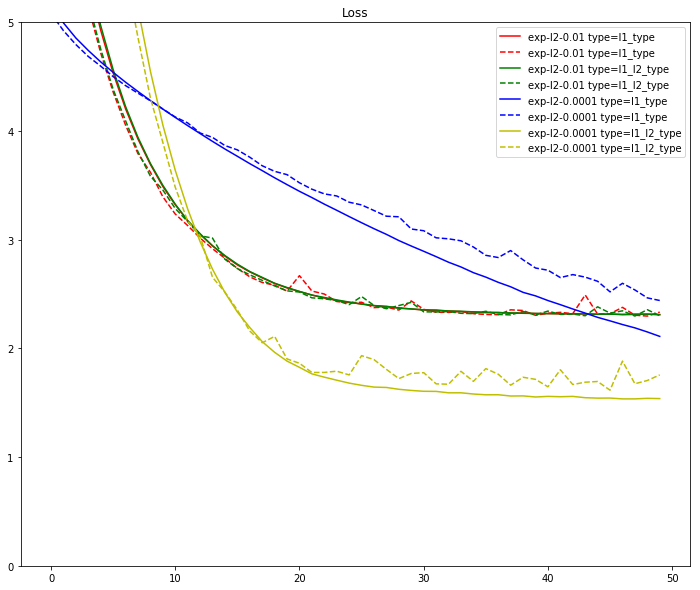

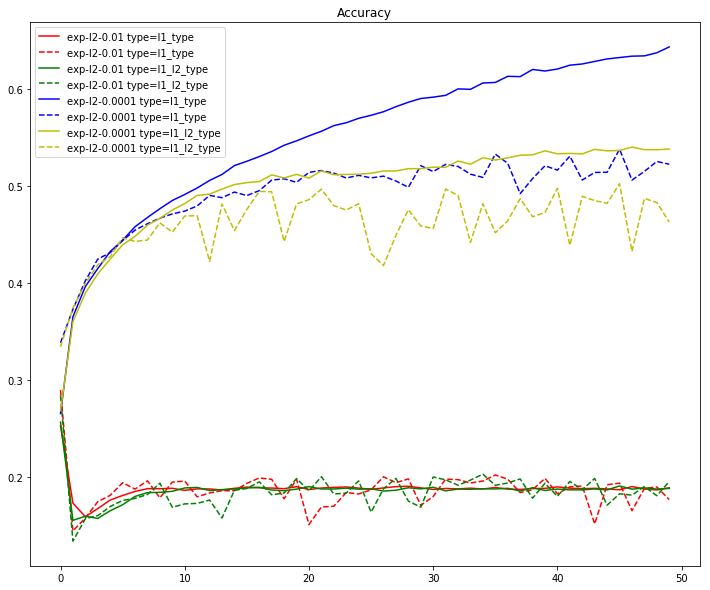

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k","black",'gray']

plt.figure(figsize=(12,10))
for i, cond in enumerate(results.keys()):
    if i<4:
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(12,10))
for i, cond in enumerate(results.keys()):
    if i<4:
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

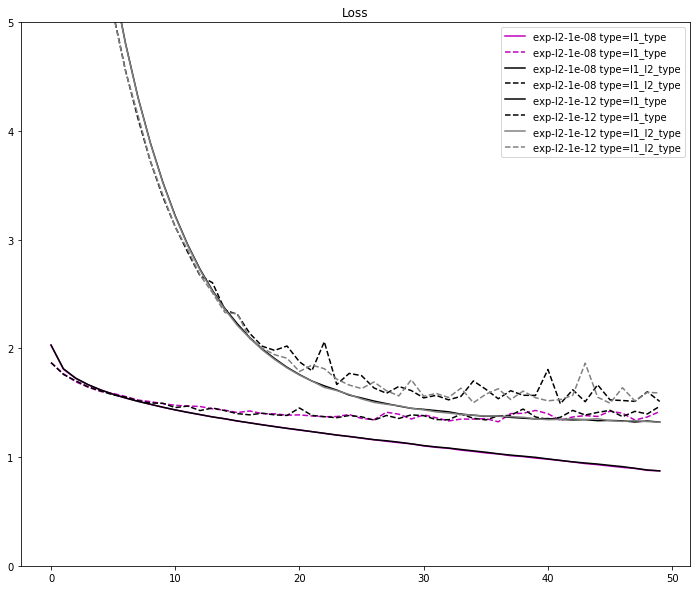

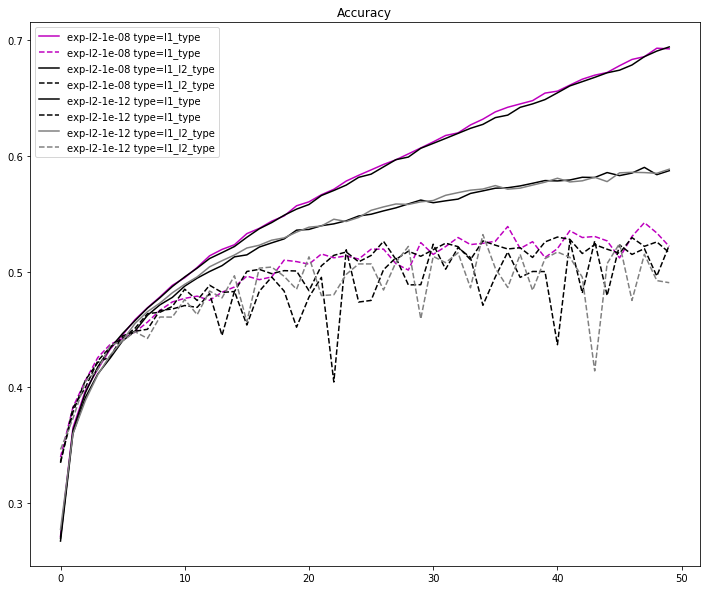

In [12]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k","black",'gray']

plt.figure(figsize=(12,10))
for i, cond in enumerate(results.keys()):
    if i>=4 and i<8:
        plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(12,10))
for i, cond in enumerate(results.keys()):
    if i>=4 and i<8:
        plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
        plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()

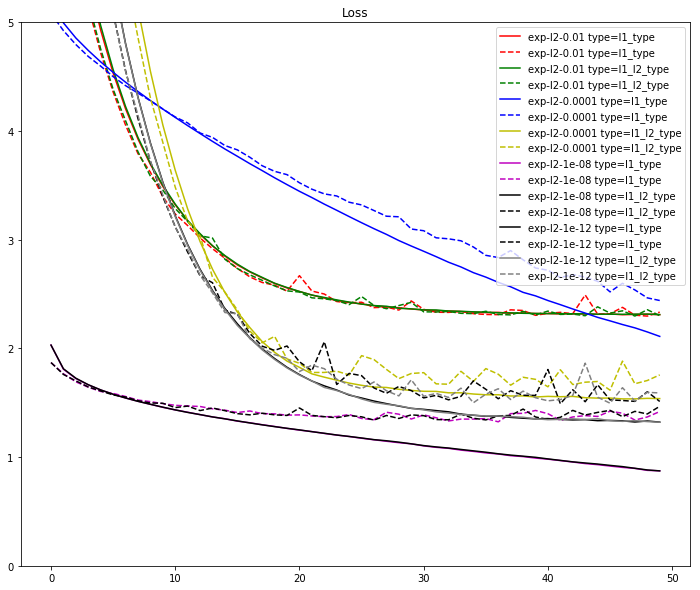

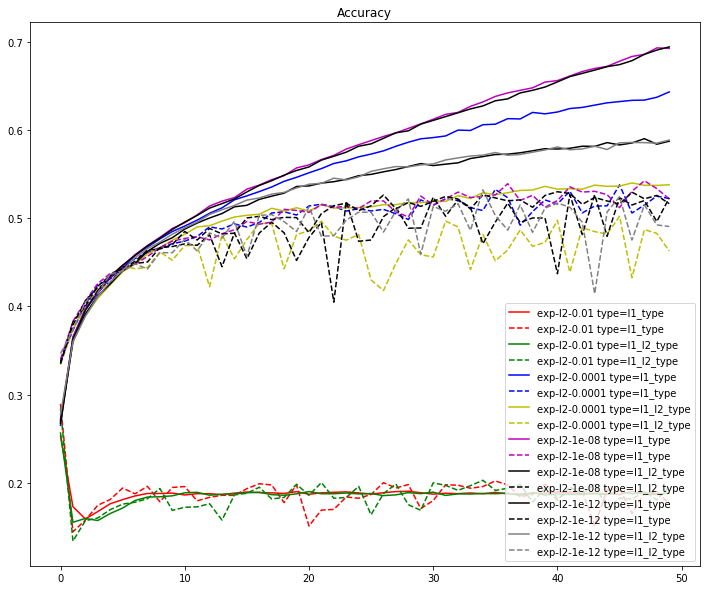

In [14]:
import matplotlib.pyplot as plt
%matplotlib inline
"""Code Here
將結果繪出
"""
color_bar = ["r", "g", "b", "y", "m", "k","black",'gray']

plt.figure(figsize=(12,10))
for i, cond in enumerate(results.keys()):
    plt.plot(range(len(results[cond]['train-loss'])),results[cond]['train-loss'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-loss'])),results[cond]['valid-loss'], '--', label=cond, color=color_bar[i])
plt.title("Loss")
plt.ylim([0, 5])
plt.legend()
plt.show()

plt.figure(figsize=(12,10))
for i, cond in enumerate(results.keys()):    
    plt.plot(range(len(results[cond]['train-acc'])),results[cond]['train-acc'], '-', label=cond, color=color_bar[i])
    plt.plot(range(len(results[cond]['valid-acc'])),results[cond]['valid-acc'], '--', label=cond, color=color_bar[i])
plt.title("Accuracy")
plt.legend()
plt.show()